In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
import sys, os
from copy import copy
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import getdist
from getdist.gaussian_mixtures import Mixture2D
from getdist.gaussian_mixtures import GaussianND
from getdist import plots, loadMCSamples
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from glob import glob

In [2]:
getdist.__version__

'1.4.7'

In [3]:
import seaborn as sns
name='colorblind'
collist=sns.color_palette(name, 20)
collist


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

# Define useful functions

In [4]:
want_table = True

def strleg(stri):
    newstri = stri.split('/')[-1]
    newstri = newstri.replace('.progress', '')
    newstri = newstri.replace('.paramnames', '')
    return newstri

def repstr(str):
    stt = str.replace('.progress','')
    stt = stt.replace('.paramnames','')
    return stt

def extract_from_logparam(filename, quantity='means', paramstype="sampled"):
    quant_dict= {'mean':0, 'min':1, 'max':2, '1-sigma':3, 'scale':4, 'role':5}
    ## Montepython log.param convention
    #quant = quant_dict[quantity]
    # Open the file and read its contents
    with open(filename, 'r') as file:
        file_content = file.read()
    # Initialize an empty dictionary to hold the cosmological parameters and their mean values.
    paramlog_dict = {}
    variation_dict = {}
    priors_dict = {}
    # Iterate through each line of the file content.
    for line in file_content.split('\n'):
        # Check if the line contains a cosmological parameter definition.
        # This is determined by the line starting with "data.parameters['" and containing "'cosmo'".
        #if line.strip().startswith("data.parameters['") and "'cosmo'" in line:
        if line.strip().startswith("data.parameters['"):
            # Extract the parameter name by splitting the line at brackets and quotes.
            parts = line.split('=')
            param_name = parts[0].split('[')[1].split(']')[0].strip("'")
            # Extract the values list, trim the brackets, and split by commas.
            values = parts[1].strip()[1:-1].split(',')
            # The first value in the list is the mean value, which we convert to float.
            mean_value = float(values[0].strip())
            sigma_value = float(values[3].strip())
            if values[1].strip()=='None':
                v1='NaN' 
            if values[2].strip()=='None':
                v2 = 'NaN'
            else:
                v1=values[1].strip()
                v2=values[2].strip()
            minmax_value = [float(v1), float(v2)]
            # Add the parameter name and mean value to our dictionary.
            paramlog_dict[param_name] = mean_value
            variation_dict[param_name] = sigma_value
            priors_dict[param_name] = minmax_value
    if paramstype=="sampled":
        for pp in variation_dict:
            if variation_dict[pp] == 0:
                paramlog_dict.pop(pp)
                print(pp, " param is fixed")
    if quantity=='means':
        return paramlog_dict
    elif quantity=='priors':
        return priors_dict
    elif quantity=='1-sigmas':
        return variation_dict

def setup_chains_fiducials(chain_idx=None, chaindir=None, chainfiles=list(), colorlist=collist, fiducial=dict(),
                            derived_fiducial=dict(), labels_dict=None, match_idx_colors=True,
                            ):
    if chaindir is None:
        chaindir=''
    if chain_idx is None:
        chain_idx = list(range(len(chainfiles)))
    chains = [repstr(chaindir+chainfiles[ii]) for ii in chain_idx]
    
    chain_names = [chai.split('/')[-2] for chai in chains]
    chain_dates = [repstr(chai.split('/')[-1]) for chai in chains]
    chain_datnam = dict(zip(chain_dates, chain_names))
    print("--> extracting chains from: ")
    print(chain_datnam)
    
    if labels_dict is not None:
        labels=[labels_dict[strleg(cc)] for cc in chains]
    else:
        labels=[chain_datnam[strleg(cc)] for cc in chains]
    if match_idx_colors:
        colors = [colorlist[ii] for ii in chain_idx]
    else:
        colors = colorlist
    #full_fiducial = {**fiducial, **derived_fiducial}
    return chains, labels, colors

def contour_FoM_calculator(sample, param1, param2, sigma_level=1):
    from shapely.geometry import Polygon
    contour_coords = {}
    density = sample.get2DDensityGridData(j=param1, j2=param2, num_plot_contours=3)
    contour_levels = density.contours
    contours = plt.contour(density.x, density.y, density.P, sorted(contour_levels));
    for ii, contour in enumerate(contours.collections):
        paths = contour.get_paths()
        for path in paths:
            xy = path.vertices
            x = xy[:,0]
            y = xy[:,1]
            contour_coords[ii] = list(zip(x, y))
    sigma_lvls = {3:0, 2:1, 1:2}
    poly = Polygon(contour_coords[sigma_lvls[sigma_level]])  # 0:3sigma, 1:2sigma, 2:1sigma
    area = poly.area
    FoM_area = (2.3*np.pi)/area
    return FoM_area, density

def process_samples(chains, labels, print_all=False, burn_in_fraction=0.5, colors=None,
                    mcmc_code='MP'):
    samples = []
    chains_analysis = dict()
    if colors is None:
        name='bright'
        collist=sns.color_palette(name, 20)
        itercol = iter(collist)
    for ind, chain in enumerate(chains):
        name = labels[ind]
        sample = loadMCSamples(chain, settings={'ignore_rows': burn_in_fraction})
        print('------------------------WORKING ON '+labels[ind]+'--------------------')
        print('R-1({}) with {:.0f}% of points ignored = {:.3f}'.format(name,100*burn_in_fraction,
                                                                   sample.getGelmanRubin()))
        print('-----------------------------------------------------------------------')
        p = sample.getParams()
        chaindic = {}
        chaindic['path'] = chain
        chaindic['get_covmat'] = True
        chaindic['color'] = next(itercol)
        paramobs = sample.getParamNames()
        pc = paramobs.parsWithNames(['M_c_1'])[0]
        if pc is not None:
            pc.renames = ['log10Mc_1']
            #pc.renames=['M_c_1']
        paramnames = [prr.name for prr in paramobs.names]
        print(paramnames)
        mstat=sample.getMargeStats()
        if print_all:
            for parr in paramnames:
                print(str(parr), " Mean : ", mstat.parWithName(parr).mean)
                print(str(parr), " 1sigma-Err : ", mstat.parWithName(parr).err)
                print(str(parr), " Lower : ", mstat.parWithName(parr).limits[0].lower)
                print(str(parr), " Upper: ", mstat.parWithName(parr).limits[0].upper)
                print(sample.getInlineLatex(parr))
        if 'w' in paramnames and 'wa' in paramnames:
            FoM = np.sqrt(np.linalg.det(np.linalg.inv(sample.cov(pars=['w','wa']))))
            print("Reported w0-wa FoM from covmat: {:.3f}".format(FoM))
            FoM_A, density = contour_FoM_calculator(sample=sample, param1='w', param2='wa')
            print('--'*10)
            chaindic['density'] = density
            print("Reported w0-wa FoM from contour area: {:.3f}".format(FoM_A))
        try:
            p.S8 = p.sigma8*np.sqrt(p.omegam/0.3)
            sample.addDerived(p.S8, name='S8', label='S_8')
        except: 
            print("S8 parameter could not be obtained")
            pass
        chaindic['sample'] = sample
        chaindic['paramnames'] = paramnames
        chaindic['param_samples'] = p
        chaindic['bounds'] = sample.getTable(paramList=paramnames, limit=1).tableTex()
        #chaindic['table_params_bounds'] = sample.getTable().tableParamNames

        if mcmc_code=='MP':
            chainext = '_{:d}.txt'
        elif mcmc_code=='Cobaya':
            chainext = '.{:d}.txt'
        else:
            chainext = '*{:d}*.txt'
        covext = '.covmat'
        #columns = open(chaindic['path']+chainext.format(1)).readline().rstrip().split()
        #columns.pop(0)
        allchains = glob(chaindic['path']+chainext.format(1).replace('1','*'))
        print("All chains: ", allchains)
        Nchains = len(allchains)
        print("Number of chains: ", Nchains)
        points = []
        for achain in allchains:
            try: 
                poi = pd.read_csv(achain, sep='\s+', skiprows=1, 
                              header=None, #names=columns
                              )
                points.append(poi)
            except:
                print("Chain {:s} has a strange number of entries. Just a warning.".format(achain))
                pass
        for pt in points:
            pt.drop(pt.index[:int(len(pt.index)*burn_in_fraction)], inplace=True) 
        chaindic['trends'] = points
        chaindic['points'] = points
        try:
            columns = open(chaindic['path']+'.progress').readline().rstrip().split()
            columns.pop(0)
            chaindic['progress'] = pd.read_csv(chaindic['path']+'.progress',sep='\s+', skiprows=1,header=None, names=columns)
        except:
            print('No progress file for '+chain)
        if chaindic['get_covmat']:
            try:
                mat = sample.getCovMat().matrix
                #covmat = pd.DataFrame(data=mat.astype(float))
                #covmat.to_csv(chaindic['path']+'_covmat.txt', sep=' ', header=False, index=False)
                chaindic['covmat'] = mat
            except:
                print("Cov mat not obtained")
        chains_analysis[name] = chaindic
        samples.append(sample)
    return samples, chains_analysis

def plot_chain_trends(chainsdict, labels, full_fiducial, parstoplot=None):
    lab0 = labels[0]
    chainsdict['columns'] = chainsdict['trends'][0].columns
    if parstoplot is None:
        parstoplot = chainsdict[lab0]['paramnames']
    for par in parstoplot:
        fig, axes = plt.subplots(ncols=len(labels), sharey=True, subplot_kw=dict(frameon=True), figsize=(15,5))
        for i,name in enumerate(labels):
            axes[i].set_title(name)
            if par in chainsdict[name]['columns']:
                for ch in chainsdict[name]['trends']:
                    axes[i].plot(ch.index, ch[par].values)
            axes[i].axhline(y=full_fiducial[par],ls='-',color='black',zorder=95,lw=3)
            axes[i].set_xscale("log")
            axes[i].set_xlabel('index')
            axes[i].set_ylabel(r'{:s}'.format(par))
    plt.subplots_adjust(hspace=.5)

def plot_contours(samples, parstoplot, labels, colors=collist, param_limits=dict(), markers_dict=dict(), options_dict=dict()):
    fontsize  = options_dict.get('axes_fontsize', 20)
    Ncont = len(labels)
    g = plots.get_subplot_plotter(subplot_size=1, width_inch=12, scaling=False)
    g.settings.figure_legend_frame = False
    g.settings.axes_fontsize=fontsize
    g.settings.axes_labelsize=20
    g.settings.legend_fontsize=18
    g.settings.axis_marker_color = 'black'
    g.settings.axis_marker_ls = '--'
    g.settings.axis_marker_lw = 2
    filled = options_dict.get('filled', [True]*Ncont)
    contour_args_def = [{'alpha':0.9},{'alpha':0.7},{'alpha':0.6}]
    contour_args = options_dict.get('contour_args', contour_args_def) 
    contour_ls = options_dict.get('contour_ls', ['-']*Ncont) 
    contour_lws = options_dict.get('contour_lws', [2.0]*Ncont)
    title_limit = options_dict.get('title_limit', 1) 
    g.triangle_plot(samples, parstoplot,
        filled=filled,
        #upper_roots = samples[2:],
        #upper_kwargs = 
        #{'contour_colors':['green', 'magenta'] },#, 'param_limits':paramlims},
        #upper_label_right=True,
        legend_labels=labels,
        legend_loc='upper right',
        legend_ncol=1,
        contour_colors=colors,
        contour_ls=contour_ls,
        contour_lws=contour_lws,
        #diag1d_kwargs={'line_args':{'lw':2}},
        contour_args=contour_args,
        markers=markers_dict
        , 
        title_limit=title_limit
        ,
        param_limits=param_limits
        )
    g.fig.align_ylabels()
    #g.text('Hola')
    #g.add_text(extra_text, x=0.95, y=0.75, fontsize=16, ax=None)
    return g

# Analyze Chains

In [5]:
chaindir = "../../GDrive-Kazuya/"

In [6]:
chains_list = glob(chaindir+'**/*00000*.paramnames')
chains_list

['../../GDrive-Kazuya/HS6_WL_pesbar_emantis/2023-12-28_500000_.paramnames',
 '../../GDrive-Kazuya/HS6_WL_pesbar_forge_winther/2023-12-30_500000_.paramnames',
 '../../GDrive-Kazuya/HS6_WL_optbar_forge_emantis/2023-12-24_500000_.paramnames',
 '../../GDrive-Kazuya/HS6_WL_optbar_emantis/2023-12-26_500000_.paramnames',
 '../../GDrive-Kazuya/full_GC_superpessimistic_bbn_test1/2023-03-03_100000_.paramnames',
 '../../GDrive-Kazuya/HS6_WL_pesbar_lcdm_emantis/2024-01-08_500000_.paramnames']

In [7]:
chains, labels_all, colors = setup_chains_fiducials(chainfiles=chains_list, colorlist=collist, 
                                                               #fiducial=fiducial_params,
                            #derived_fiducial=derived_fiducial, 
                            #labels_dict=chain_datnam
                            )
print(chains)
#print(colors)
print(labels_all)

--> extracting chains from: 
{'2023-12-28_500000_': 'HS6_WL_pesbar_emantis', '2023-12-30_500000_': 'HS6_WL_pesbar_forge_winther', '2023-12-24_500000_': 'HS6_WL_optbar_forge_emantis', '2023-12-26_500000_': 'HS6_WL_optbar_emantis', '2023-03-03_100000_': 'full_GC_superpessimistic_bbn_test1', '2024-01-08_500000_': 'HS6_WL_pesbar_lcdm_emantis'}
['../../GDrive-Kazuya/HS6_WL_pesbar_emantis/2023-12-28_500000_', '../../GDrive-Kazuya/HS6_WL_pesbar_forge_winther/2023-12-30_500000_', '../../GDrive-Kazuya/HS6_WL_optbar_forge_emantis/2023-12-24_500000_', '../../GDrive-Kazuya/HS6_WL_optbar_emantis/2023-12-26_500000_', '../../GDrive-Kazuya/full_GC_superpessimistic_bbn_test1/2023-03-03_100000_', '../../GDrive-Kazuya/HS6_WL_pesbar_lcdm_emantis/2024-01-08_500000_']
['HS6_WL_pesbar_emantis', 'HS6_WL_pesbar_forge_winther', 'HS6_WL_optbar_forge_emantis', 'HS6_WL_optbar_emantis', 'full_GC_superpessimistic_bbn_test1', 'HS6_WL_pesbar_lcdm_emantis']


In [8]:
choose_main_chain = 3
file_path = chaindir+labels_all[choose_main_chain]+'/'+'log.param'  # Replace 'path/to/your/folder/' with the actual path
file_path

'../../GDrive-Kazuya/HS6_WL_optbar_emantis/log.param'

In [9]:
fiducial_params = extract_from_logparam(file_path, quantity='means')
fiducial_params

betaIA  param is fixed
deta  param is fixed
sigma8_fofR  param is fixed


{'omega_b': 0.022445,
 'omega_cdm': 0.1205579307,
 'H0': 67.0,
 'ln10^{10}A_s': 3.05685,
 'n_s': 0.96,
 'lgfR0': 5.30103,
 'aIA': 1.71,
 'etaIA': -0.41,
 'log10Mc': 13.32,
 'thej': 4.235}

In [10]:
paramslims = {}
params_priors = extract_from_logparam(file_path, quantity='priors')
params_priors

betaIA  param is fixed
deta  param is fixed
sigma8_fofR  param is fixed


{'omega_b': [0.01, 0.04],
 'omega_cdm': [0.005, 1.0],
 'H0': [10.0, 150.0],
 'ln10^{10}A_s': [2.7, 3.3],
 'n_s': [0.94, 0.98],
 'lgfR0': [4.0, 7.0],
 'aIA': [0.0, 12.1],
 'etaIA': [-7.0, 6.17],
 'betaIA': [0.63, 5.0],
 'log10Mc': [11.0, 15.0],
 'thej': [2.0, 8.0],
 'deta': [0.05, 0.4],
 'sigma8_fofR': [-1.0, -1.0]}

In [11]:
parstoplot = list(fiducial_params.keys())
parstoplot = parstoplot[0:6]
parstoplot

['omega_b', 'omega_cdm', 'H0', 'ln10^{10}A_s', 'n_s', 'lgfR0']

In [12]:
print(labels_all)

['HS6_WL_pesbar_emantis', 'HS6_WL_pesbar_forge_winther', 'HS6_WL_optbar_forge_emantis', 'HS6_WL_optbar_emantis', 'full_GC_superpessimistic_bbn_test1', 'HS6_WL_pesbar_lcdm_emantis']


In [13]:
chain_indices = [2,3] ## from list of labels/chains
chains, labels, colors = setup_chains_fiducials(chainfiles=chains_list, chain_idx=chain_indices,  
                                                                          colorlist=collist, 
                                                                          fiducial=fiducial_params,
                                                                        )

samples, chainsdict = process_samples(chains, labels, print_all=True)

--> extracting chains from: 
{'2023-12-24_500000_': 'HS6_WL_optbar_forge_emantis', '2023-12-26_500000_': 'HS6_WL_optbar_emantis'}
------------------------WORKING ON HS6_WL_optbar_forge_emantis--------------------
R-1(HS6_WL_optbar_forge_emantis) with 50% of points ignored = 0.014
-----------------------------------------------------------------------
['omega_b', 'omega_cdm', 'H0', 'ln10^{10}A_s', 'n_s', 'lgfR0', 'aIA', 'etaIA', 'log10Mc', 'thej', 'sigma8_fofR']


omega_b  Mean :  0.022446886658445384
omega_b  1sigma-Err :  0.0003645700337809261
omega_b  Lower :  0.0220835
omega_b  Upper:  0.02280786
\omega{}_{b } = 0.02245\pm 0.00036
omega_cdm  Mean :  0.12167079287919767
omega_cdm  1sigma-Err :  0.0034145451252441767
omega_cdm  Lower :  0.1182987
omega_cdm  Upper:  0.1250348
\omega{}_{cdm } = 0.1217\pm 0.0034
H0  Mean :  65.61367984047065
H0  1sigma-Err :  0.8168905404644314
H0  Lower :  64.80028
H0  Upper:  66.43526
H0 = 65.61\pm 0.82
ln10^{10}A_s  Mean :  3.034395379184637
ln10^{10}A_s  1sigma-Err :  0.043044977188704786
ln10^{10}A_s  Lower :  2.991554
ln10^{10}A_s  Upper:  3.076764
ln10^{10}A_{s } = 3.034\pm 0.043
n_s  Mean :  0.9599051879901055
n_s  1sigma-Err :  0.00396732359310476
n_s  Lower :  0.955972
n_s  Upper:  0.9638405
n_{s } = 0.9599\pm 0.0040
lgfR0  Mean :  6.08667800968535
lgfR0  1sigma-Err :  0.4239915638474526
lgfR0  Lower :  5.529447152824625
lgfR0  Upper:  6.399686806372433
lgfR0 = 6.09^{+0.31}_{-0.56}
aIA  Mean :  1.699315

In [14]:
labels

['HS6_WL_optbar_forge_emantis', 'HS6_WL_optbar_emantis']

In [15]:
chainsdict[labels[0]].keys()

dict_keys(['path', 'get_covmat', 'color', 'sample', 'paramnames', 'param_samples', 'bounds', 'trends', 'points', 'covmat'])

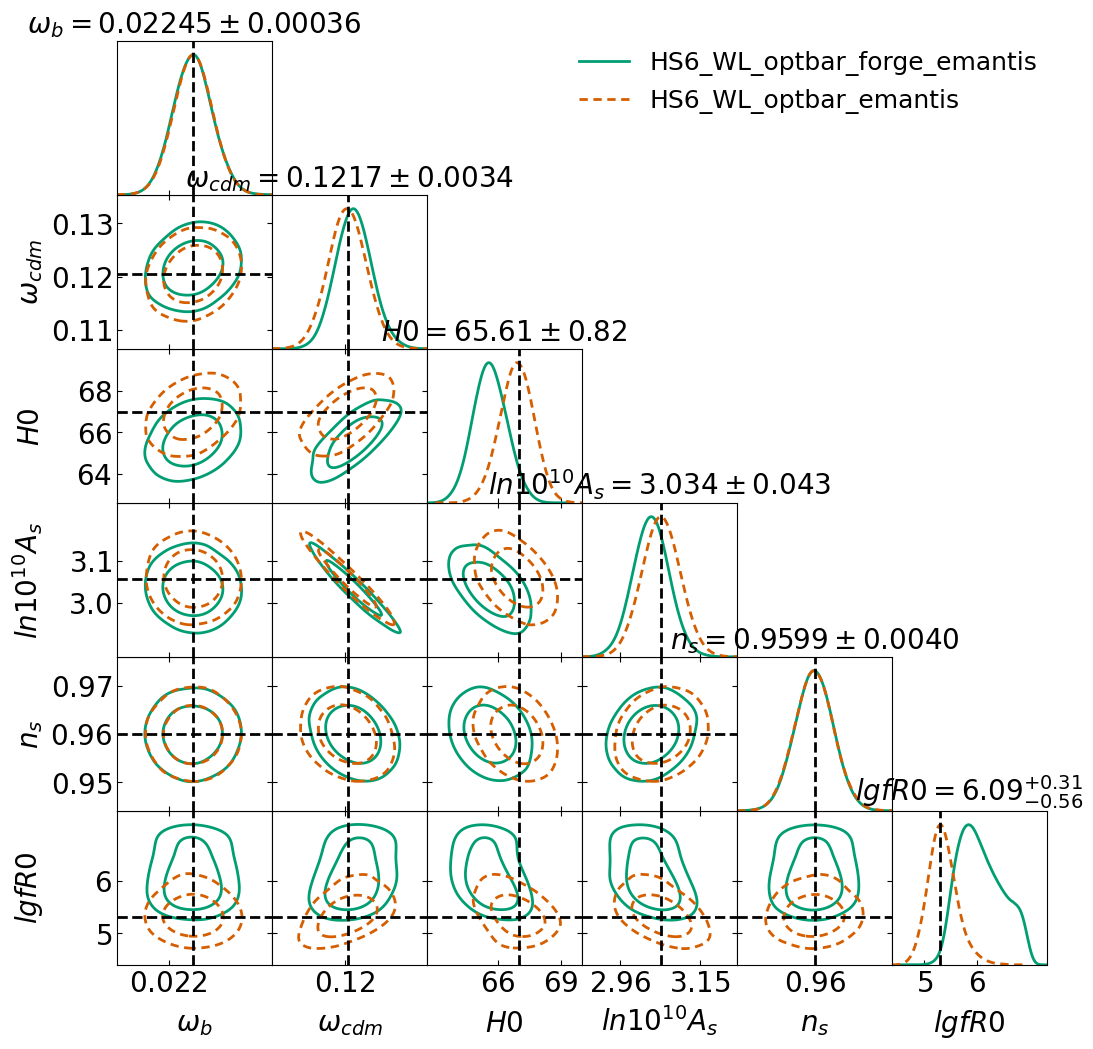

In [16]:
gplot = plot_contours(samples, parstoplot, labels, colors=colors, param_limits=paramslims, 
                     markers_dict=fiducial_params, 
options_dict={
 'filled': [False, False, True], 
  'contour_args' : [{'lw':3, 'ls':'--'}, {'lw':3, 'ls':'-'}], 
  'contour_ls' : ['-', '--', '--', '-']
})
#plt.show()

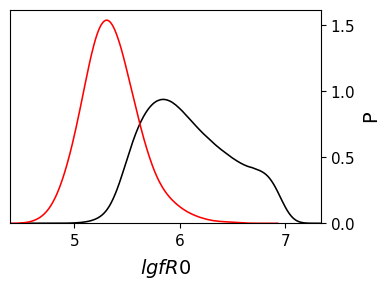

In [17]:
g = plots.get_single_plotter(width_inch=4)
g.plot_1d(samples, 'lgfR0', normalized=True, label_right=True)

In [18]:
labels

['HS6_WL_optbar_forge_emantis', 'HS6_WL_optbar_emantis']

In [19]:
chainsdict[labels[0]]['paramnames']

['omega_b',
 'omega_cdm',
 'H0',
 'ln10^{10}A_s',
 'n_s',
 'lgfR0',
 'aIA',
 'etaIA',
 'log10Mc',
 'thej',
 'sigma8_fofR']

## Compute Bounds for Chain 0

In [20]:
labels[0]

'HS6_WL_optbar_forge_emantis'

In [21]:
chainInfo = chainsdict[labels[0]]
chainInfo['sample']

In [22]:
chainInfo.keys()

dict_keys(['path', 'get_covmat', 'color', 'sample', 'paramnames', 'param_samples', 'bounds', 'trends', 'points', 'covmat'])

In [23]:
chainInfo['paramnames']

['omega_b',
 'omega_cdm',
 'H0',
 'ln10^{10}A_s',
 'n_s',
 'lgfR0',
 'aIA',
 'etaIA',
 'log10Mc',
 'thej',
 'sigma8_fofR']

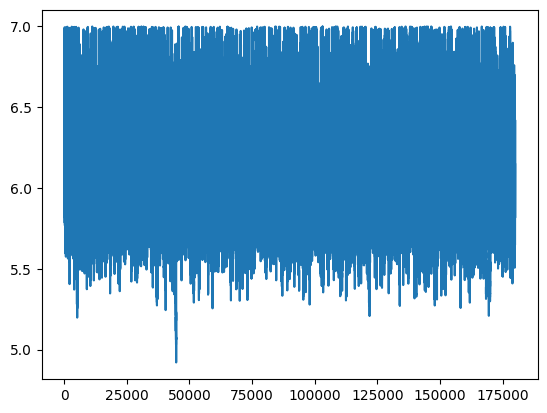

In [24]:
plt.plot(chainInfo['param_samples'].lgfR0)

In [25]:
#abschainloc = os.path.abspath(chainloc)
#mcAnaly = plots.MCSampleAnalysis(chain_locations=abschainloc)
#mcSamples = mcAnaly.samples_for_root(root='HS6_WL_pesbar_forge_winther', file_root=abschainloc, settings={'ignore_rows': 0.3})
#dens1d = mcAnaly.get_density(root='HS6_WL_pesbar_forge_winther', param='H0')

In [26]:
dens1D = chainInfo['sample'].get1DDensity('lgfR0')
dens1D

In [ ]:
dens1D.

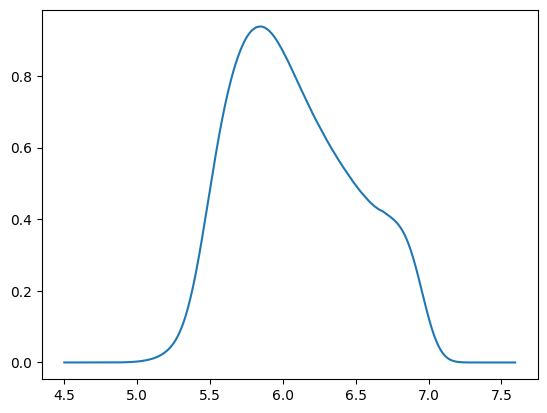

In [27]:
plt.plot(dens1D.x, dens1D.P)

In [28]:
densParr = np.array([dens1D.x, dens1D.P]).T

In [29]:
x1 = dens1D.x[np.argmax(dens1D.P)]
x1

5.84957470188714

In [30]:
print(dens1D.getLimits([0.95]))
dens1D.bounds()

(5.40869607342049, 6.9158728141478445, False, False)


[4.7589817489220385, 7.336197251077961]

In [31]:
# Default limits are 1: 68%, 2: 95%, 3: 99% probability enclosed
print(chainInfo['sample'].getInlineLatex('lgfR0',limit=2))

lgfR0 = 6.09^{+0.84}_{-0.67}


In [32]:
Bf = 2.5 # Bf: Bayes factor : B(x1, x2) =  b(x1; d,p) / b(x2; d,p)

In [33]:
params_priors['lgfR0']

[4.0, 7.0]

In [34]:
fiducial_params['lgfR0']

5.30103

In [35]:
#x1 = 5.30103 #4 #7  #4.27  # or 7?

In [36]:
bx1 = dens1D.Prob(x=x1)
print(bx1)

0.9383471085723543


In [37]:
#bx2 = bx1 / B(x1,x2)

In [38]:
def Bayes(x2, x1=x1):
    ret = dens1D.Prob(x=x1)/dens1D.Prob(x=x2)
    return ret

In [39]:
from scipy import optimize

In [40]:
def funopt(x2):
    ret = dens1D.Prob(x2)*Bf - bx1
    return ret

In [41]:
xxf = np.linspace(4, 7.3, 100)

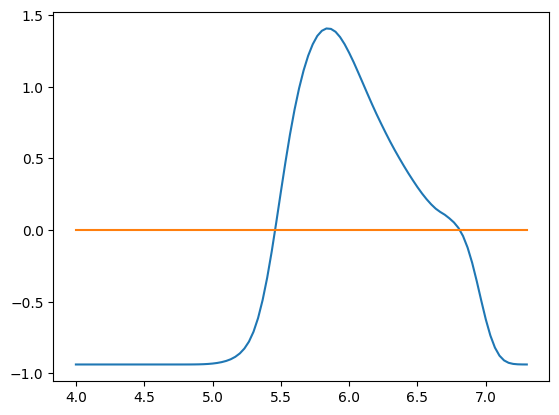

In [42]:
plt.plot(xxf, funopt(xxf))
plt.plot(xxf, np.zeros_like(xxf))

In [43]:
xx1=5.2; xx2=5.6
print(funopt(xx1), funopt(xx2))  #find two numbers by hand with opposite signs

-0.8609759466313148 0.838950984312496


In [44]:
xy1=6.5; xy2=6.9
print(funopt(xy1), funopt(xy2))  #find two numbers by hand with opposite signs

0.2989268257295419 -0.22831411780362587


In [45]:
soldown = optimize.root_scalar(funopt, x0=xx1, x1=xx2,
                           method='secant')

In [46]:
soldown

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 5.457896550919199

In [47]:
soldown.root

5.457896550919199

In [48]:
val, Solup = optimize.brentq(funopt, xy1, xy2, full_output=True)
print(Solup)

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 6.809781021196602


In [49]:
Solup.root

6.809781021196602

In [50]:
funopt(soldown.root)

-2.220446049250313e-15

In [51]:
funopt(Solup.root)

2.220446049250313e-16

In [52]:
Bayes(soldown.root)

2.5000000000000058

In [53]:
Bayes(Solup.root)

2.4999999999999996

### Compare bounds

In [54]:
## 95% from samples alone
print(dens1D.getLimits([0.95]))

(5.40869607342049, 6.9158728141478445, False, False)


In [55]:
print(soldown.root, Solup.root)

5.457896550919199 6.809781021196602


## Compare against profile likelihood

In [162]:
chi2_lgfR0 = np.load('./chi2_lgfR0.npz')
x_data = chi2_lgfR0['x']
y_data = chi2_lgfR0['y']
print(chi2_lgfR0['x'])
print(chi2_lgfR0['y'])
print(chi2_lgfR0['interval1'])
print(chi2_lgfR0['interval2'])

[5.388   5.53854 5.848   6.0827  6.24566]
[1.73947073 1.13919872 0.82461273 1.05410374 1.24572447]
[5.49364548 6.29350147]
[5.22707942 6.41897218]


In [87]:
from scipy.interpolate import InterpolatedUnivariateSpline as intp1

In [124]:
chi2spli = intp1(x_data, y_data, k=4)

In [125]:
dens1D.x

array([4.5012602 , 4.50428333, 4.50730645, ..., 7.58787255, 7.59089567,
       7.5939188 ])

In [156]:
xl = np.linspace(4.7, 7., 1000)

In [157]:
np.max(dens1D.P)

0.9383471085723543

In [158]:
np.trapz(dens1D.P, x=dens1D.x)

0.9999999999998577

In [159]:
ychi = np.exp(-0.5*chi2spli(xl))
normi = np.trapz(ychi, x=xl)
print(normi)

0.9475904453512951


In [160]:
print(dens1D.getLimits([0.95]))

(5.40869607342049, 6.9158728141478445, False, False)


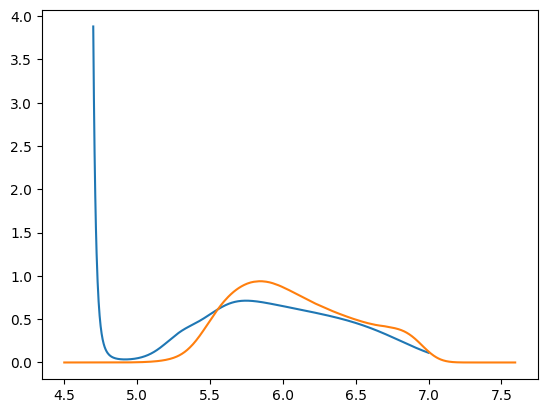

In [161]:
plt.plot(xl, ychi/normi)
plt.plot(dens1D.x, dens1D.P)

## Compute Bounds for Chain 1

In [133]:
labels[1]

'HS6_WL_optbar_emantis'

In [94]:
chainInfo = chainsdict[labels[1]]
chainInfo['sample']

In [95]:
chainInfo.keys()

dict_keys(['path', 'get_covmat', 'color', 'sample', 'paramnames', 'param_samples', 'bounds', 'trends', 'points', 'covmat'])

In [96]:
chainInfo['paramnames']

['omega_b',
 'omega_cdm',
 'H0',
 'ln10^{10}A_s',
 'n_s',
 'lgfR0',
 'aIA',
 'etaIA',
 'log10Mc',
 'thej',
 'sigma8_fofR']

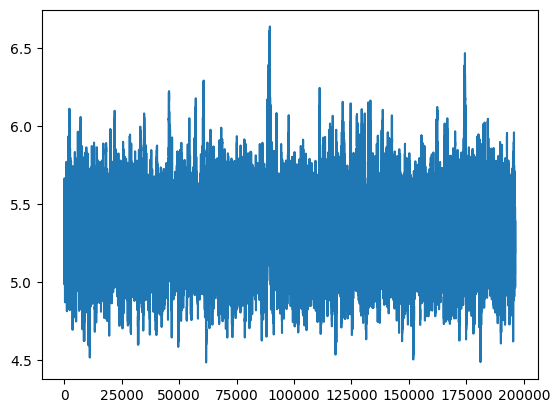

In [97]:
plt.plot(chainInfo['param_samples'].lgfR0)

In [98]:
#abschainloc = os.path.abspath(chainloc)
#mcAnaly = plots.MCSampleAnalysis(chain_locations=abschainloc)
#mcSamples = mcAnaly.samples_for_root(root='HS6_WL_pesbar_forge_winther', file_root=abschainloc, settings={'ignore_rows': 0.3})
#dens1d = mcAnaly.get_density(root='HS6_WL_pesbar_forge_winther', param='H0')

In [99]:
dens1D = chainInfo['sample'].get1DDensity('lgfR0')
dens1D

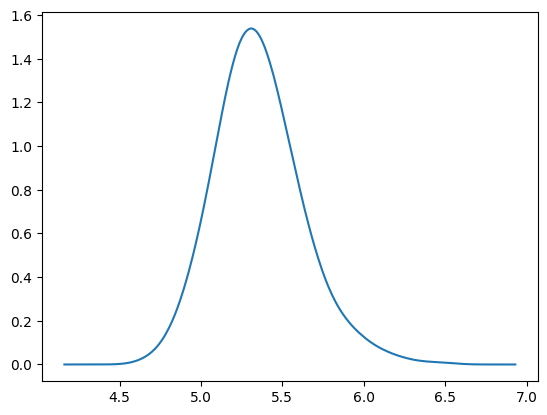

In [100]:
plt.plot(dens1D.x, dens1D.P)

In [101]:
print(dens1D.getLimits([0.95]))
dens1D.bounds()

(4.810792599314789, 5.927099355565953, False, False)


[4.392091989513822, 6.700143010486178]

In [102]:
# Default limits are 1: 68%, 2: 95%, 3: 99% probability enclosed
print(chainInfo['sample'].getInlineLatex('lgfR0',limit=2))

lgfR0 = 5.35^{+0.57}_{-0.54}


In [103]:
Bf = 2.5 # Bf: Bayes factor : B(x1, x2) =  b(x1; d,p) / b(x2; d,p)

In [104]:
params_priors['lgfR0']

[4.0, 7.0]

In [105]:
fiducial_params['lgfR0']

5.30103

In [108]:
x1 = dens1D.x[np.argmax(dens1D.P)]
x1

5.309220767642133

In [109]:
#x1 = 6.9 #4 #7  #4.27  # or 7?

In [110]:
bx1 = dens1D.Prob(x=x1)
print(bx1)

1.5386902832907499


In [111]:
#bx2 = bx1 / B(x1,x2)

In [112]:
def Bayes(x2, x1=x1):
    ret = dens1D.Prob(x=x1)/dens1D.Prob(x=x2)
    return ret

In [113]:
from scipy import optimize

In [114]:
def funopt(x2):
    ret = dens1D.Prob(x2)*Bf - bx1
    return ret

In [115]:
xxf = np.linspace(4, 7.3, 100)

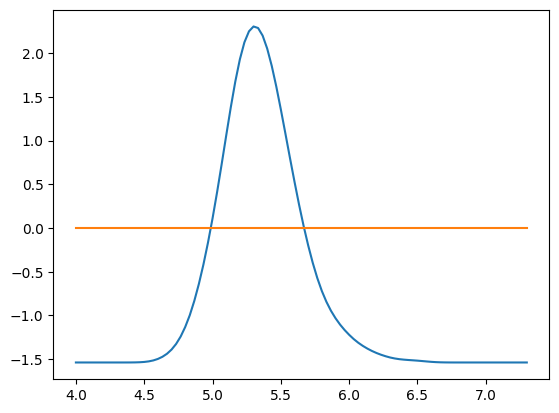

In [116]:
plt.plot(xxf, funopt(xxf))
plt.plot(xxf, np.zeros_like(xxf))

In [118]:
xx1=4.8; xx2=5.1
print(funopt(xx1), funopt(xx2))  #find two numbers by hand with opposite signs

-1.132812863312349 1.0566005309592321


In [120]:
xy1=5.5; xy2=5.9
print(funopt(xy1), funopt(xy2))  #find two numbers by hand with opposite signs

1.3551586973888847 -1.0321941329075817


In [121]:
soldown = optimize.root_scalar(funopt, x0=xx1, x1=xx2,
                           method='secant')

In [122]:
soldown

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 4.987244509233095

In [123]:
soldown.root

4.987244509233095

In [124]:
val, Solup = optimize.brentq(funopt, xy1, xy2, full_output=True)
print(Solup)

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 5.66995409434068


In [125]:
Solup.root

5.66995409434068

In [126]:
funopt(soldown.root)

-2.1715962361668062e-13

In [127]:
funopt(Solup.root)

2.9558577807620168e-12

In [128]:
Bayes(soldown.root)

2.5000000000003526

In [129]:
Bayes(Solup.root)

2.499999999995197

### Compare bounds

In [130]:
## 95% from samples alone
print(dens1D.getLimits([0.95]))

(4.810792599314789, 5.927099355565953, False, False)


In [131]:
print(soldown.root, Solup.root)

4.987244509233095 5.66995409434068
